#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.



### (3) 추가 과제
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Aivle/미니프로젝트/1차_스마트폰'

In [ ]:
%cd '{path}'

/content/drive/MyDrive/Aivle/미니프로젝트/1차_스마트폰


### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder


* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [ ]:
# 주어진 데이터 셋을 불러오세요.
train = pd.read_csv('data01_train.csv')
test = pd.read_csv('data01_test.csv')
features = pd.read_csv('features.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요.
for i in (train, test):
    i.drop('subject', axis=1, inplace=True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
# 전체 데이터의 행, 열 개수를 확인
print(train.shape)
print(test.shape)

(5881, 562)
(1471, 562)


In [ ]:
# 전체 데이터의 상위 5개 행 확인
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
# 전체 데이터의 수치형 변수 분포 확인
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [ ]:
#(추가) 다양하게 기본 정보들을 확인하세요!
features.value_counts()

sensor       agg                axis         feature_name                        
tGravityAcc  std()              Z            tGravityAcc-std()-Z                     1
angle        X                  gravityMean  angle(X,gravityMean)                    1
             Y                  gravityMean  angle(Y,gravityMean)                    1
             Z                  gravityMean  angle(Z,gravityMean)                    1
tGravityAcc  iqr()              Y            tGravityAcc-iqr()-Y                     1
                                                                                    ..
fBodyAcc     bandsEnergy()      1,16.1       fBodyAcc-bandsEnergy()-1,16.1           1
                                1,16         fBodyAcc-bandsEnergy()-1,16             1
angle        tBodyGyroMean      gravityMean  angle(tBodyGyroMean,gravityMean)        1
             tBodyGyroJerkMean  gravityMean  angle(tBodyGyroJerkMean,gravityMean)    1
             tBodyAccMean       gravity      angle(tBodyAccMean,gravity)             1
Name: count, Length: 436, dtype: int64

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
# Activity 에 대해서 단변량 분석을 시행합니다. (범주별 빈도수, 종류, 비율, 시각화도 해보기!)
target = train['Activity']

In [ ]:
target.value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


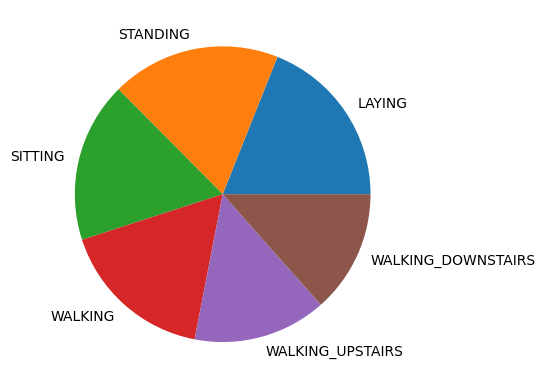

In [ ]:
plt.pie(target.value_counts(), labels = target.value_counts().index)
plt.show()

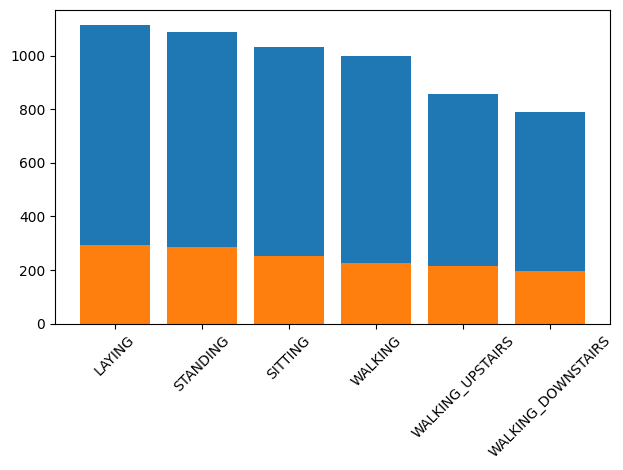

In [ ]:
data01_train_Activity = train['Activity'].value_counts()
data01_test_Activity = test['Activity'].value_counts()

plt.bar(x=data01_train_Activity.index.astype(str), height=data01_train_Activity.values)
plt.bar(x=data01_test_Activity.index.astype(str), height=data01_test_Activity.values)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [ ]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
features['sensor'].value_counts()

,count
sensor,
fBodyGyro,79
fBodyAccJerk,79
fBodyAcc,79
tBodyAcc,40
tGravityAcc,40
tBodyAccJerk,40
tBodyGyroJerk,40
tBodyGyro,40
tGravityAccMag,13


In [ ]:
#센서 그룹 데이터의 'agg'변수의 값 확인
features['agg'].value_counts()

,count
agg,
bandsEnergy(),126
arCoeff(),60
std(),33
mad(),33
max(),33
energy(),33
min(),33
entropy(),33
iqr(),33


In [ ]:
#센서 그룹 데이터의 'axis'변수의 값 확인
features['axis'].value_counts()

,count
axis,
X,76
Y,76
Z,76
gravityMean,6
"X,2",5
...,...
"17,32.2",2
"49,64.2",2
"1,24.2",2


## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [ ]:
# 데이터 분할을 위한 전처리
train['is_dynamic'] = train.loc[:, 'Activity'].map(lambda a: 0 if a in ['LAYING', 'STANDING', 'SITTING'] else 1)
test['is_dynamic'] = test.loc[:, 'Activity'].map(lambda a: 0 if a in ['LAYING', 'STANDING', 'SITTING'] else 1)

le = LabelEncoder()
train['y2'] = le.fit_transform(train['Activity'])
test['y2'] = le.transform(test['Activity'])

X = train.drop(['Activity', 'is_dynamic', 'y2'], axis=1)
y = train.loc[:, 'Activity']
is_dynamic = train.loc[:, 'is_dynamic']
y2 = train.loc[:, 'y2']

X_train, X_val, y_train, y_val = train_test_split(X, y2, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(4704, 561) (1177, 561) (4704,) (1177,)


#### 2) 모델링

In [ ]:
#생성
baseline = RandomForestClassifier(random_state=42)
#학습
baseline.fit(X_train, y_train)
#평가
y_pred = baseline.predict(X_val)
print(confusion_matrix(y_val, y_pred))

[[231   0   0   0   0   0]
 [  0 196   4   0   0   0]
 [  0   9 217   0   0   0]
 [  0   0   0 194   2   2]
 [  0   0   0   2 142   1]
 [  0   0   0   0   3 174]]


#### 3) 변수 중요도 추출

In [ ]:
# 변수 중요도 추출(시각화로 나타내기)

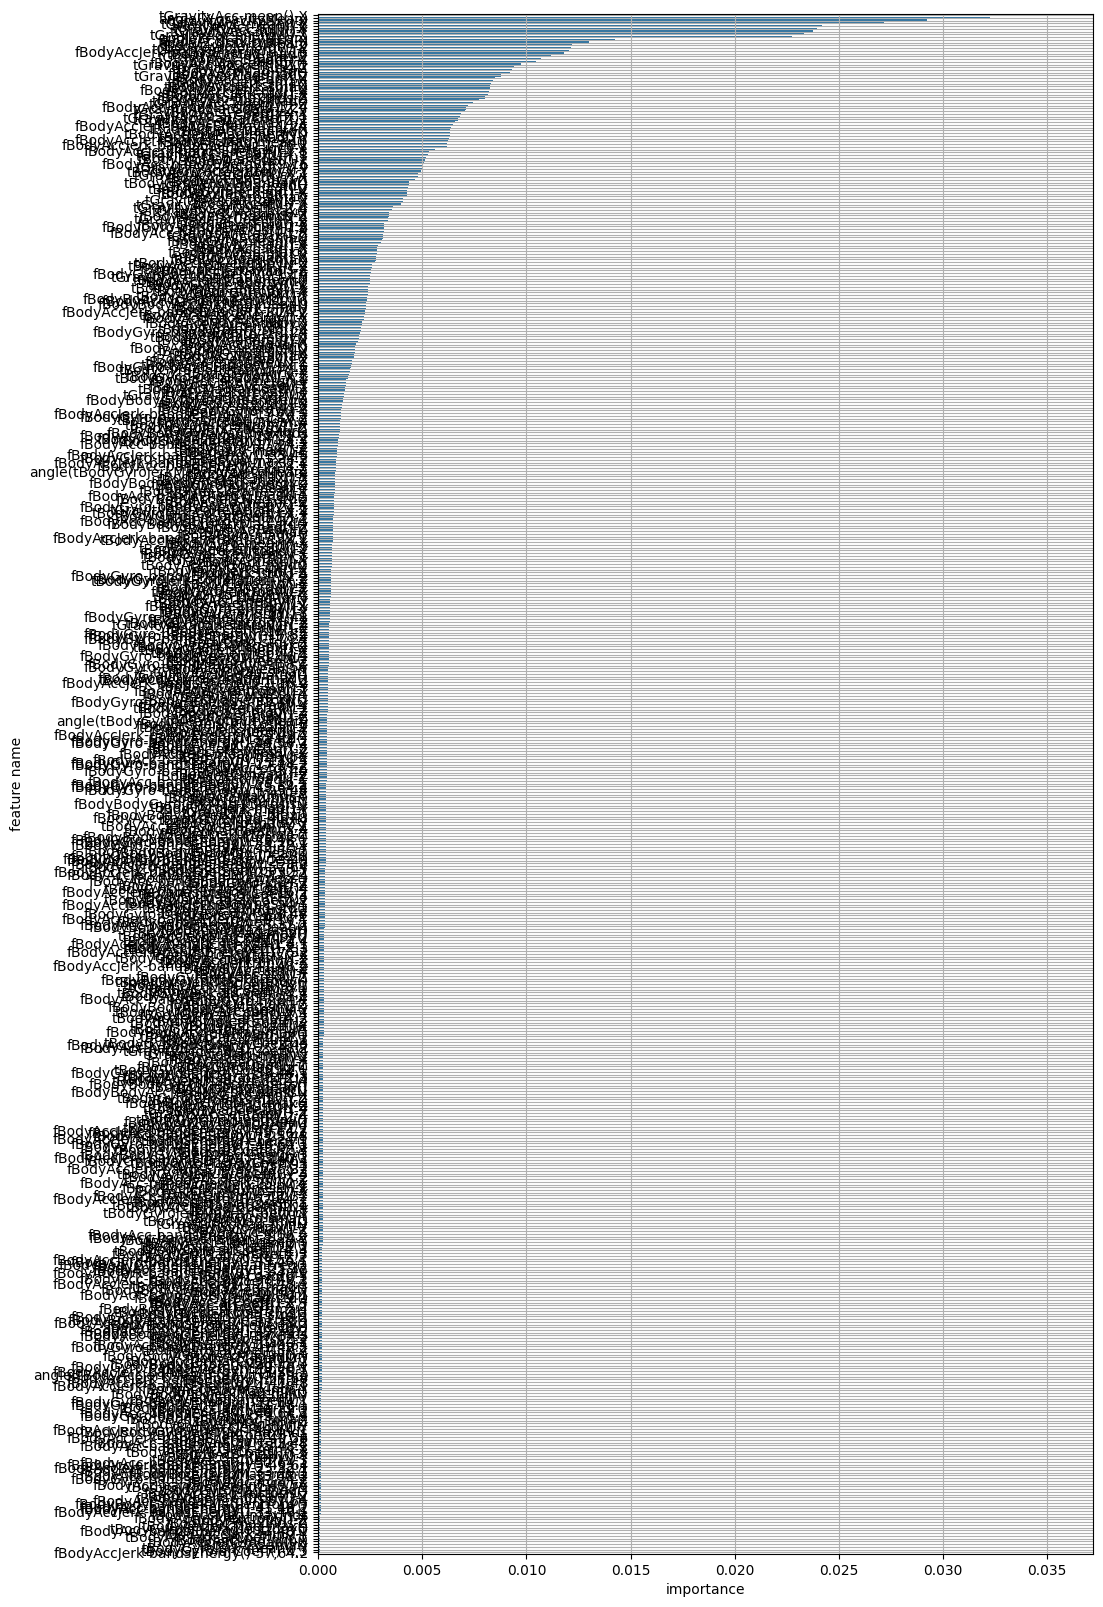

In [ ]:
# 변수 중요도 추출(시각화로 나타내기)
y2_fi = plot_feature_importance(baseline.feature_importances_, baseline.feature_names_in_, topn='all')

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
# 중요도 상위 top 5
top5 = plot_feature_importance(baseline.feature_importances_, baseline.feature_names_in_, result_only=True, topn=5)
top5

,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.035434
1,"angle(X,gravityMean)",0.032244
2,tGravityAcc-max()-X,0.029213
3,tGravityAcc-mean()-Y,0.027175
4,tGravityAcc-min()-X,0.024205


In [ ]:
# 중요도 하위 top 5
low5 = plot_feature_importance(baseline.feature_importances_, baseline.feature_names_in_, result_only=True, topn='all')[-5:]
low5

,feature_name,feature_importance
556,tBodyAccJerk-mean()-X,0.000095
557,fBodyAcc-sma(),0.000093
558,tBodyGyroJerk-mean()-Y,0.000085
559,"tBodyGyro-arCoeff()-X,3",0.000076
560,"fBodyAccJerk-bandsEnergy()-57,64.2",0.000073


#### 2) 상위 5개 변수에 대한 분석
        - 위에서 나온 상위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

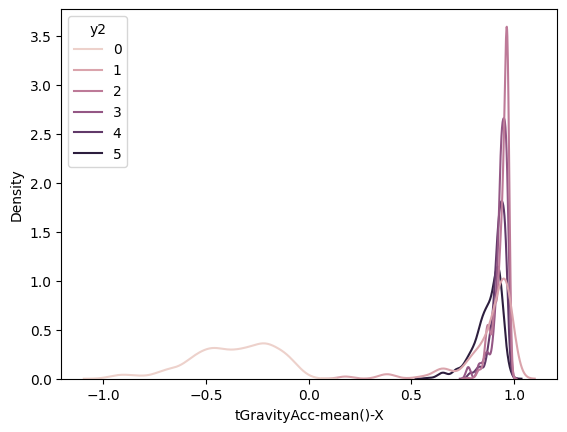

In [ ]:
#1위 :	tGravityAcc-mean()-X
top_feature = top5.iloc[0]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='y2')
plt.show()


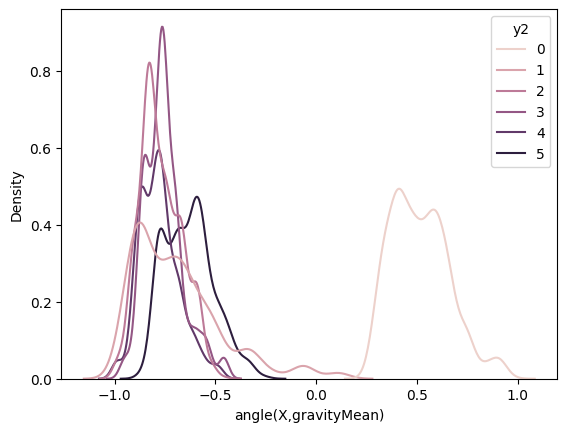

In [ ]:
#2위: angle(X,gravityMean)
top_feature = top5.iloc[1]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='y2')
plt.show()

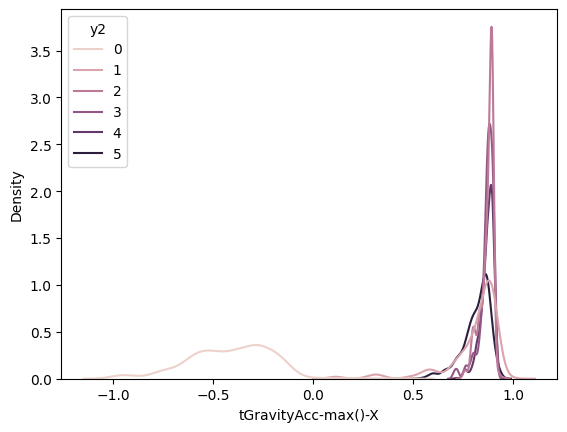

In [ ]:
#3위: tGravityAcc-max()-X
top_feature = top5.iloc[2]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='y2')
plt.show()

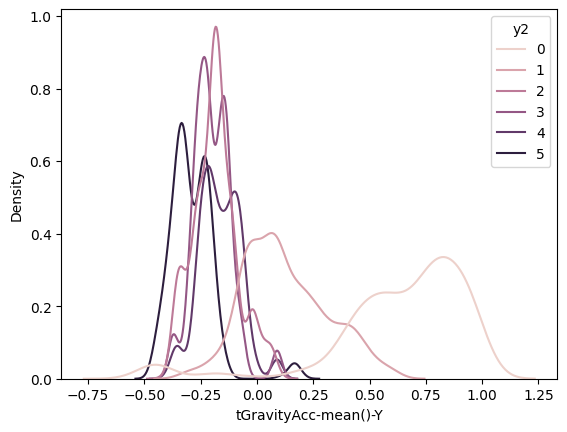

In [ ]:
#4위: tGravityAcc-mean()-Y
top_feature = top5.iloc[3]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='y2')
plt.show()

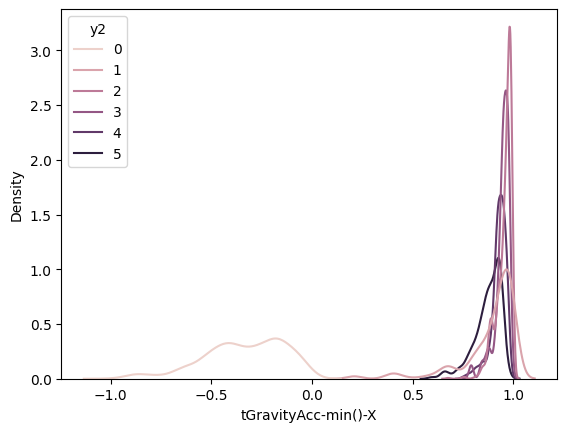

In [ ]:
#5위: tGravityAcc-min()-X
top_feature = top5.iloc[4]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='y2')
plt.show()

#### 3) 하위 5개 변수에 대한 분석
        - 위에서 하위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

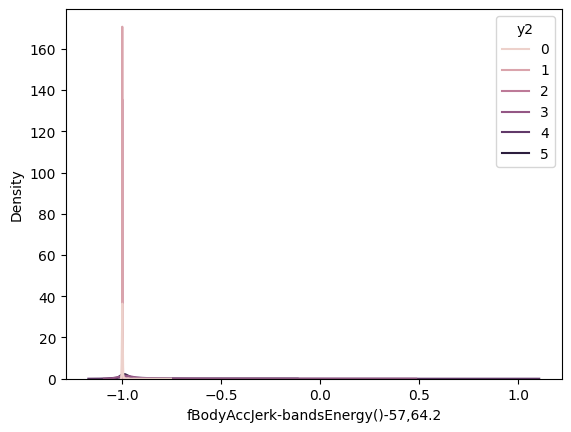

In [ ]:
#1위 : tBodyAccJerkMag-arCoeff()3
top_feature = low5.iloc[-1]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='y2')
plt.show()

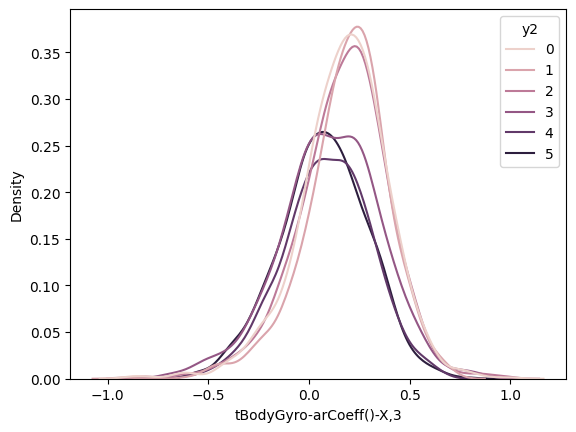

In [ ]:
#2위: tGravityAccMag-max()
top_feature = low5.iloc[-2]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='y2')
plt.show()

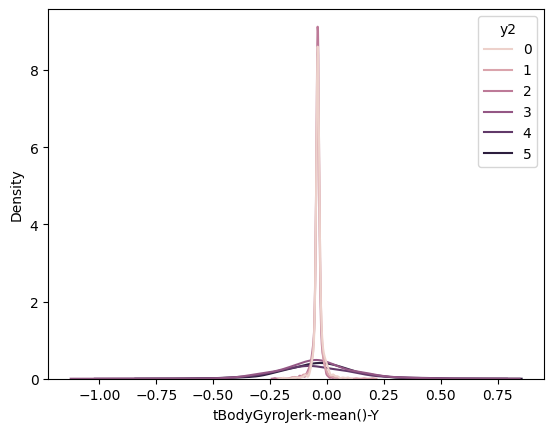

In [ ]:
#3위: tGravityAccMag-min()
top_feature = low5.iloc[-3]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='y2')
plt.show()

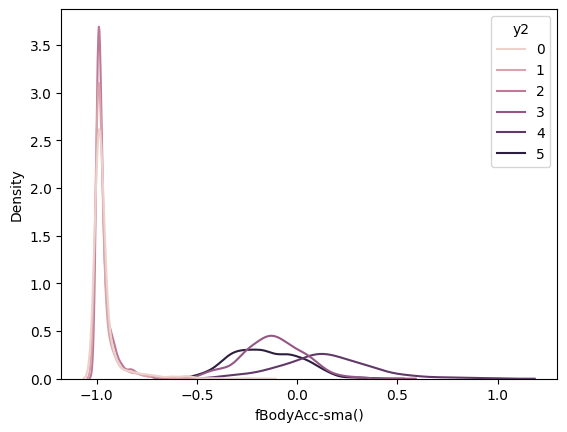

In [ ]:
#4위: tGravityAccMag-energy()
top_feature = low5.iloc[-4]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='y2')
plt.show()

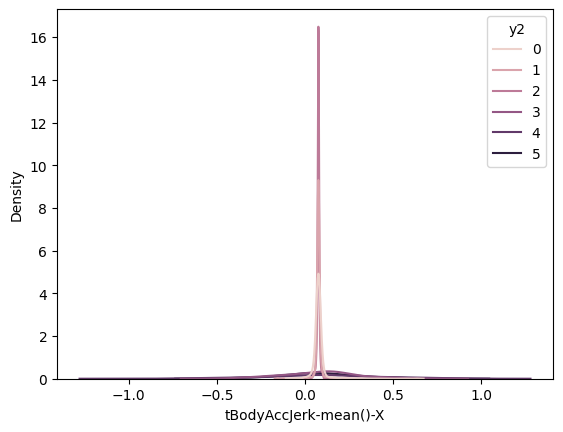

In [ ]:
#5위: tGravityAccMag-iqr()
top_feature = low5.iloc[-5]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='y2')
plt.show()

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.


#### 1) 결과 merge

In [ ]:
merged_features = pd.merge(features, y2_fi, on='feature_name')

#### 2) sensor 별 중요도

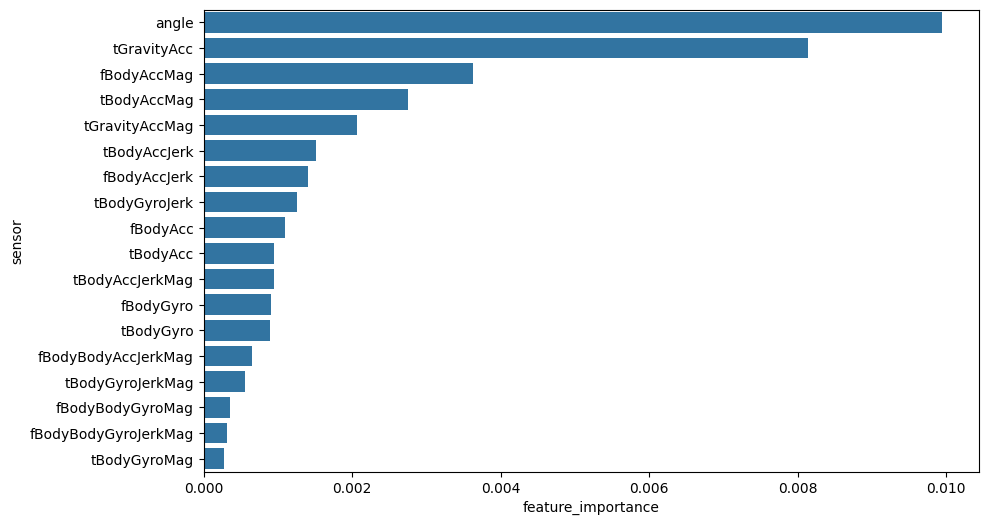

In [ ]:
# sensor 별 중요도 그래프 그리기
sorted_df = merged_features.groupby('sensor', as_index=False)['feature_importance'].mean().sort_values('feature_importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_df, x='feature_importance', y='sensor')
plt.show()

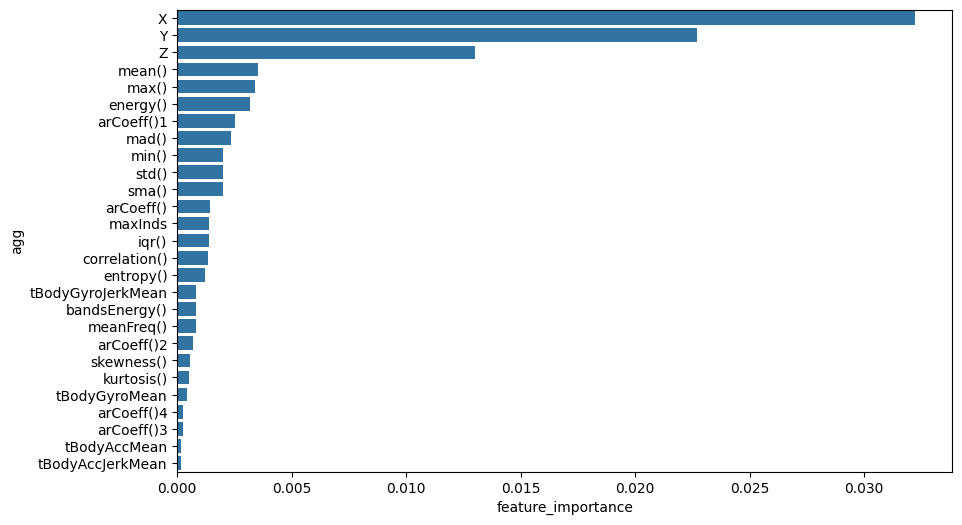

In [ ]:
# agg 별 중요도 그래프 그리기
sorted_df = merged_features.groupby('agg', as_index=False)['feature_importance'].mean().sort_values('feature_importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_df, x='feature_importance', y='agg')
plt.show()

#### 3) sensor + agg 별 중요도

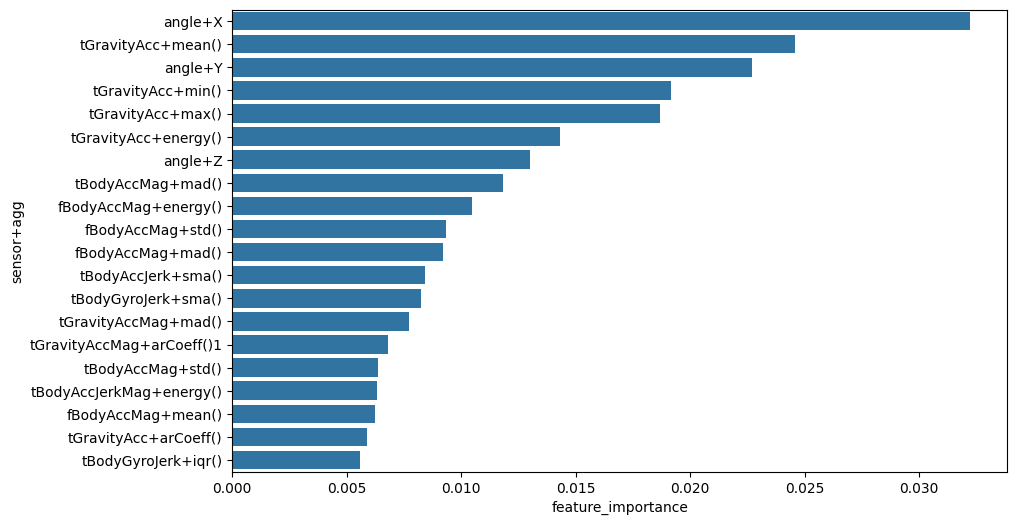

In [ ]:
# 상위 20개만 조회하여 그래프 그리기
merged_features['sensor+agg'] = merged_features['sensor'] + '+' + merged_features['agg']
sorted_df = merged_features.groupby('sensor+agg', as_index=False)['feature_importance'].mean().sort_values('feature_importance', ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(data=sorted_df, x='feature_importance', y='sensor+agg')
plt.show()

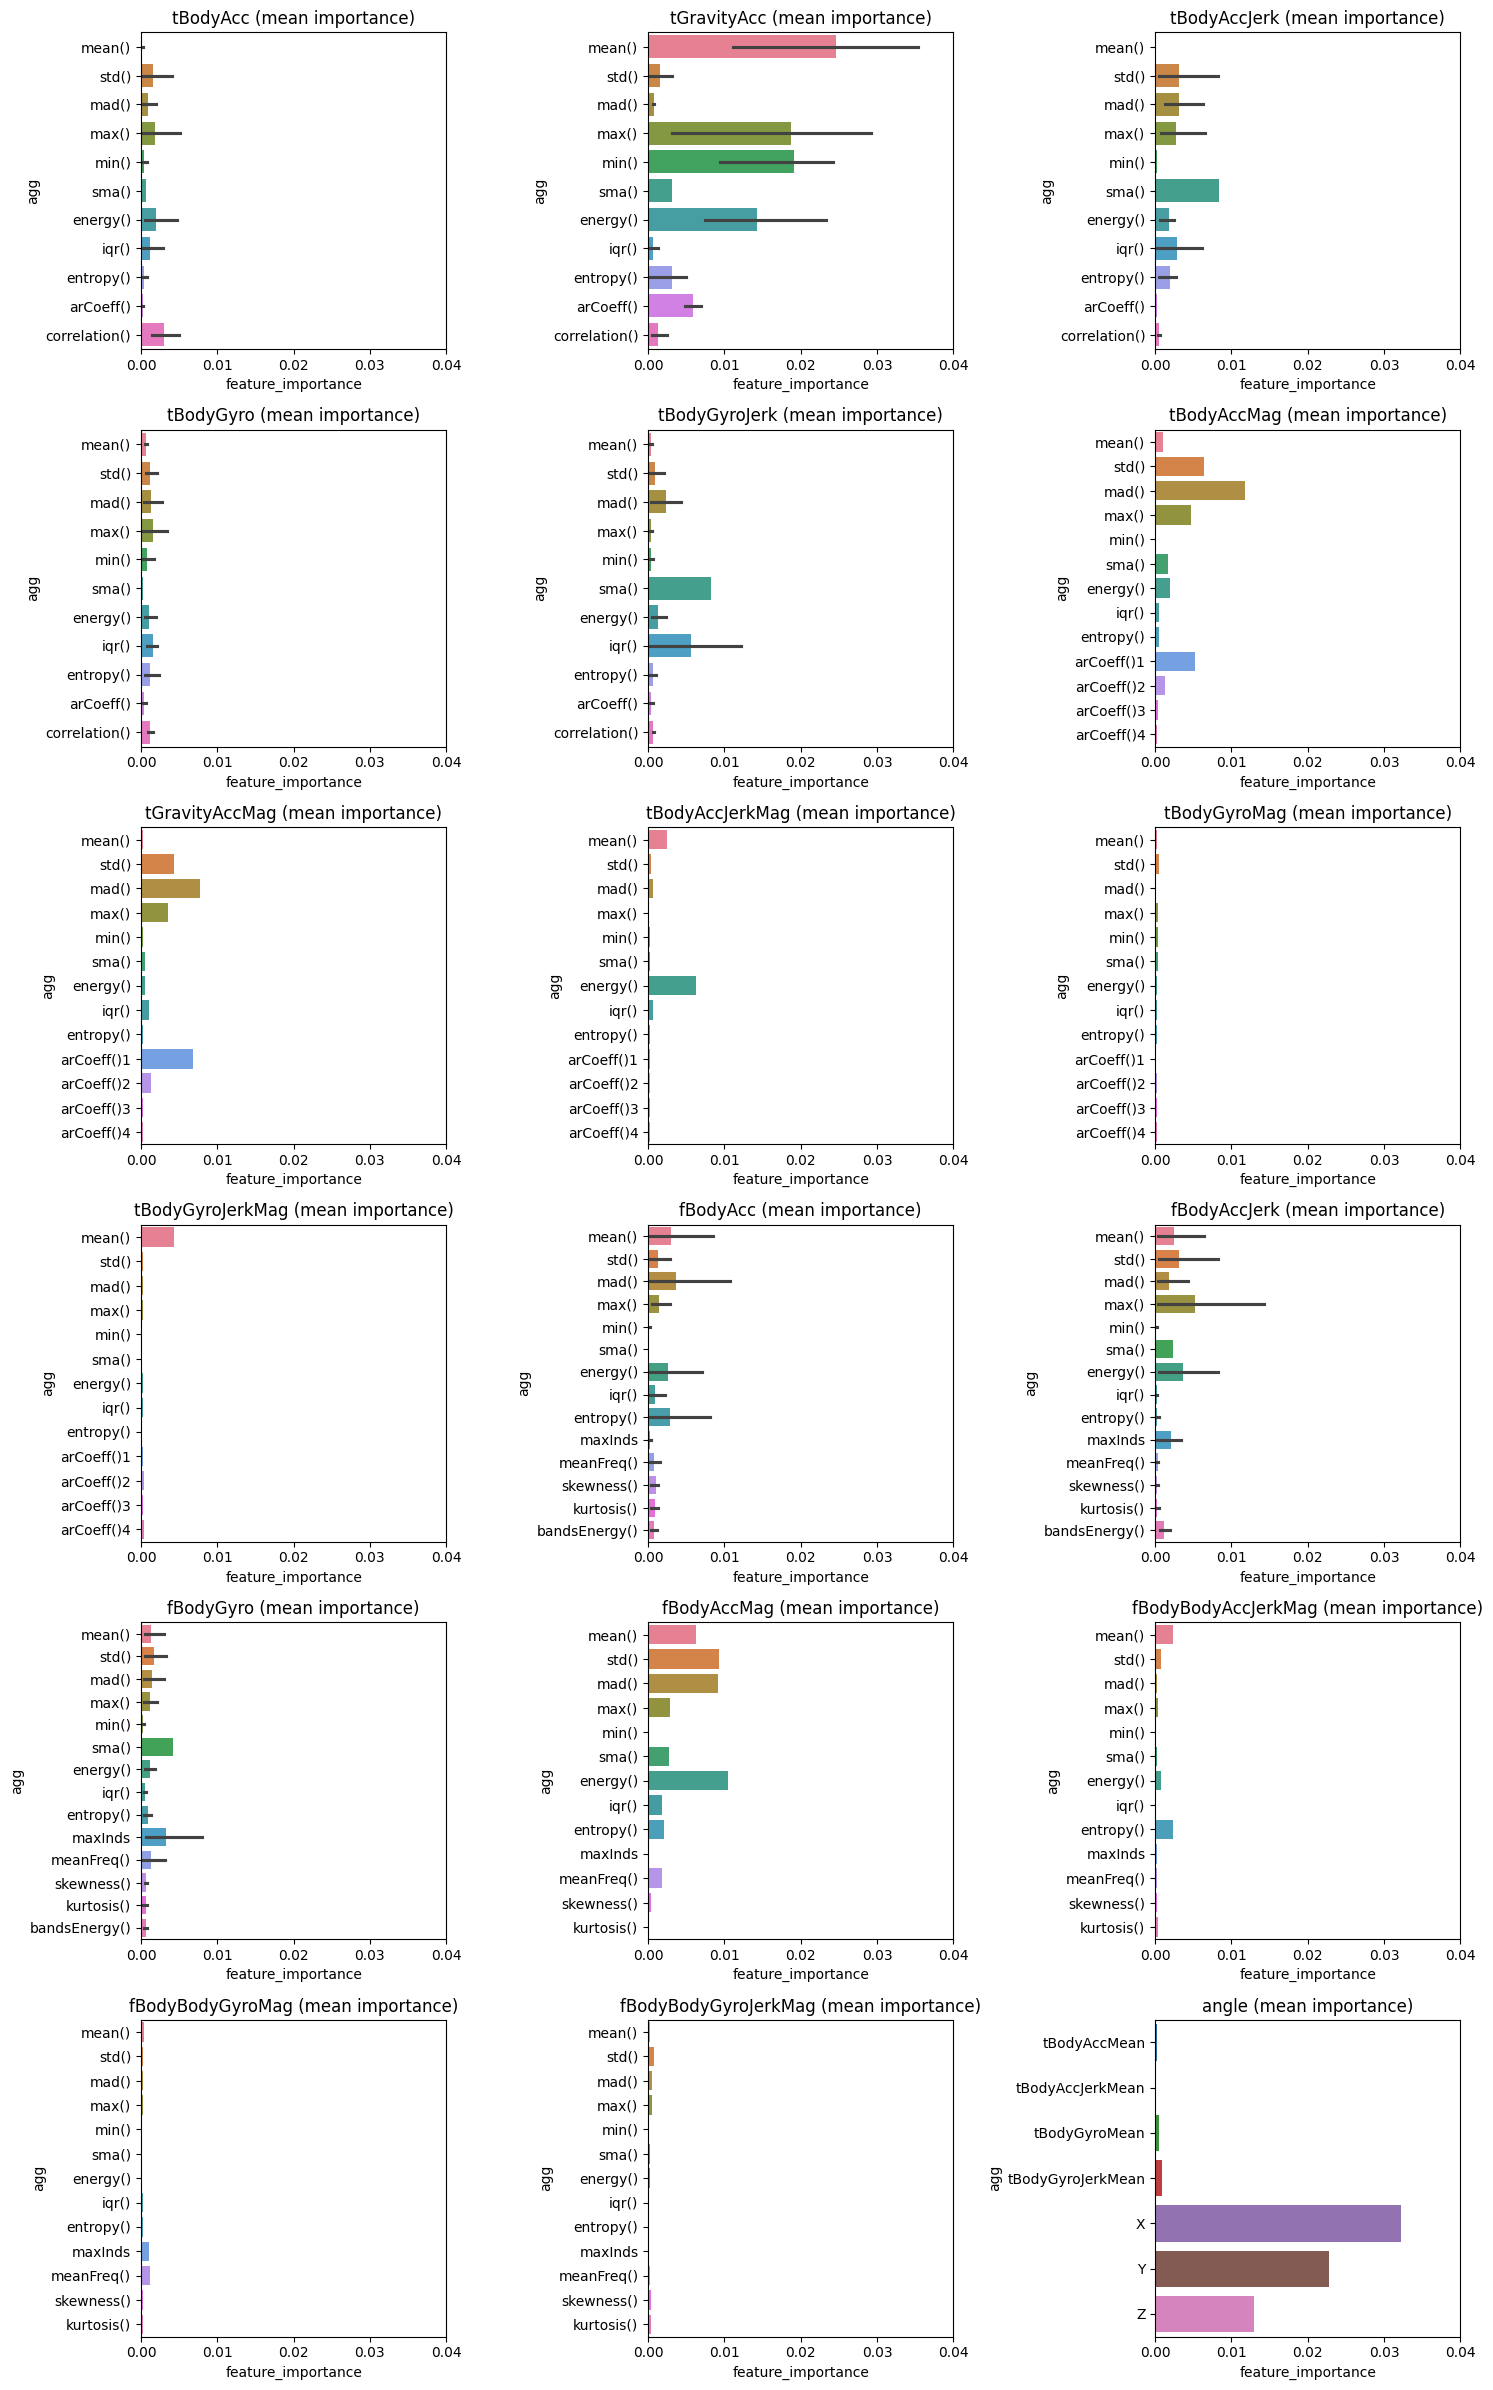

In [ ]:
# Sensor 별, agg로 나눠서 분석하기
sensors = merged_features['sensor'].unique()
n = len(sensors)

cols = 3
rows = (n + cols - 1) // cols
plt.figure(figsize=(15, 4 * rows))

for i, sensor in enumerate(sensors):
    plt.subplot(rows, cols, i + 1)
    subset = merged_features[merged_features['sensor'] == sensor]
    sns.barplot(
        data=subset,
        x='feature_importance',
        y='agg',
        hue='agg',
        estimator='mean',
    )
    plt.title(f'{sensor} (mean importance)')
    plt.xlim(0, 0.04)
plt.tight_layout()
plt.show()


## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [ ]:
#is dynamic 변수를 추가하세요(값 0, 값 1 확인해서!)

#### 2) 기본모델 생성

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
X_train, X_val, y_train, y_val = train_test_split(X, is_dynamic, test_size=0.3, random_state=42)

In [ ]:
#RandomForestClassifier로 모델링 진행
#RandomForestClassifier로 모델링 진행
#생성
baseline = RandomForestClassifier(random_state=42)
#학습
baseline.fit(X_train, y_train)
#평가
y_pred = baseline.predict(X_val)
print(confusion_matrix(y_val, y_pred))

[[957   0]
 [  0 808]]


In [ ]:
# 데이터 분할을 위한 전처리
train['is_dynamic'] = train.loc[:, 'Activity'].map(lambda a: 0 if a in ['LAYING', 'STANDING', 'SITTING'] else 1)
test['is_dynamic'] = test.loc[:, 'Activity'].map(lambda a: 0 if a in ['LAYING', 'STANDING', 'SITTING'] else 1)

le = LabelEncoder()
train['y2'] = le.fit_transform(train['Activity'])
test['y2'] = le.transform(test['Activity'])

X = train.drop(['Activity', 'is_dynamic', 'y2'], axis=1)
y = train.loc[:, 'Activity']
is_dynamic = train.loc[:, 'is_dynamic']
y2 = train.loc[:, 'y2']

X_train, X_val, y_train, y_val = train_test_split(X, y2, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, is_dynamic, test_size=0.3, random_state=42)


#### 3) 변수중요도 상위 5개 분석

In [ ]:
# is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석!
top5 = plot_feature_importance(baseline.feature_importances_, baseline.feature_names_in_, result_only=True, topn=5)
top5

,feature_name,feature_importance
0,fBodyAccJerk-max()-X,0.060310
1,tBodyGyroJerk-iqr()-Z,0.059794
2,"fBodyAccJerk-bandsEnergy()-1,16",0.050049
3,tBodyAccJerk-std()-X,0.050000
4,fBodyAcc-entropy()-X,0.049745


* 미션1에서 했던 것 처럼 상위 5개의 변수 데이터를 탐색해보기!

In [ ]:
train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,y2
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0,2
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0,2
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1,3
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0,1
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1,5
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1,5


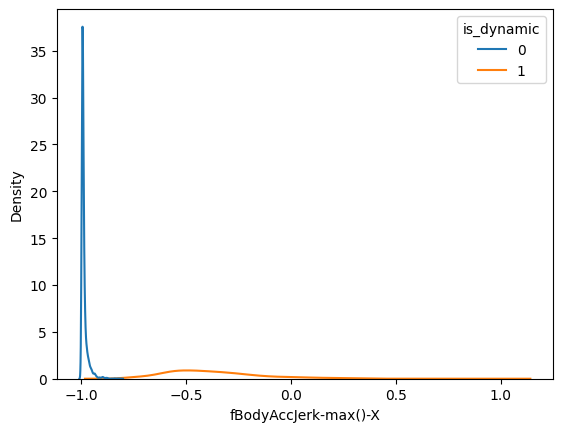

In [ ]:
#1위 :	fBodyAccJerk-max()-X
top_feature = top5.iloc[0]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='is_dynamic')
plt.show()

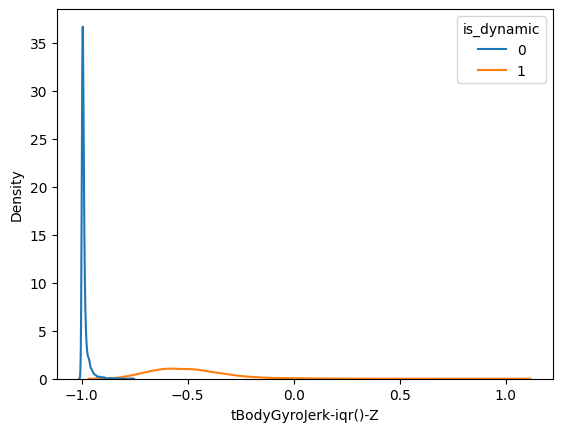

In [ ]:
#2위:tBodyGyroJerk-iqr()-Z
top_feature = top5.iloc[1]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='is_dynamic')
plt.show()


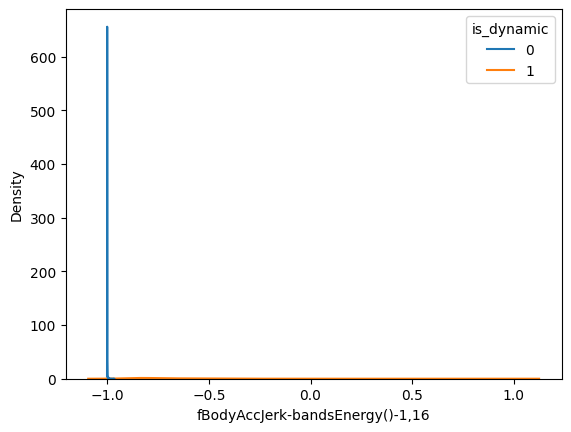

In [ ]:
#3위: fBodyAccJerk-bandsEnergy()-1,16
top_feature = top5.iloc[2]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='is_dynamic')
plt.show()


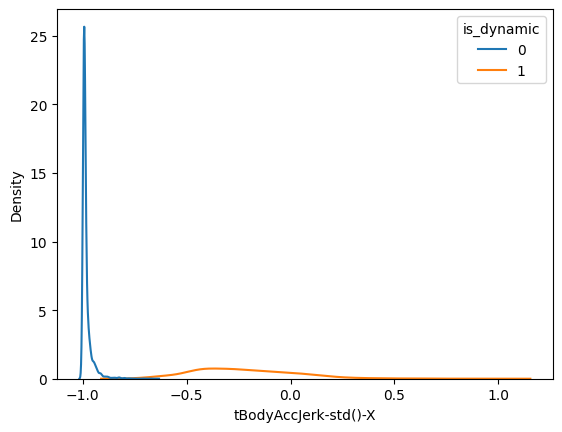

In [ ]:
#4위: tBodyAccJerk-std()-X
top_feature = top5.iloc[3]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='is_dynamic')
plt.show()


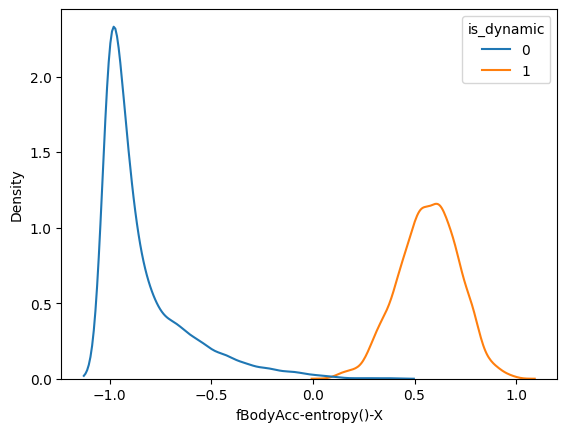

In [ ]:
#5위: fBodyAcc-entropy()-X
top_feature = top5.iloc[4]['feature_name']
sns.kdeplot(data=train, x=top_feature, hue='is_dynamic')
plt.show()


#### 4) feature 그룹별 분석

* 결과 merge

In [ ]:
dynamic_features = plot_feature_importance(baseline.feature_importances_, baseline.feature_names_in_, result_only=True, topn='all')
dynamic_features.rename(columns={'feature_importance': 'is_dynamic_importance'}, inplace=True)
merged_features = pd.merge(merged_features, dynamic_features, on='feature_name')

In [ ]:
merged_features

,sensor,agg,axis,feature_name,feature_importance,sensor+agg,is_dynamic_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000138,tBodyAcc+mean(),0.000029
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000263,tBodyAcc+mean(),0.000035
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000142,tBodyAcc+mean(),0.000030
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004068,tBodyAcc+std(),0.000098
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000280,tBodyAcc+std(),0.000038
...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000446,angle+tBodyGyroMean,0.000000
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000839,angle+tBodyGyroJerkMean,0.000000
558,angle,X,gravityMean,"angle(X,gravityMean)",0.032244,angle+X,0.000166
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.022725,angle+Y,0.000000


* sensor 별 중요도

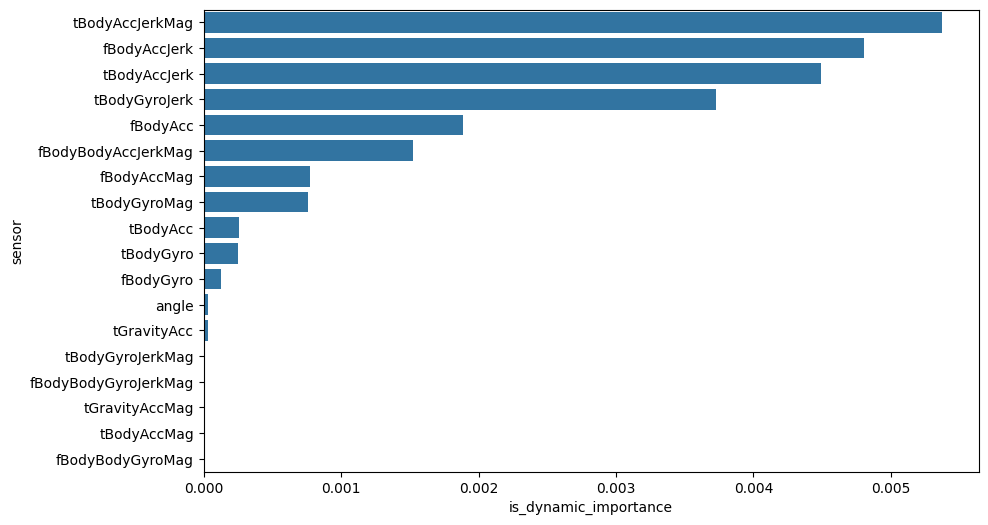

In [ ]:
# sensor 별 중요도 그래프 그리기
sorted_df = merged_features.groupby('sensor', as_index=False)['is_dynamic_importance'].mean().sort_values('is_dynamic_importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_df, x='is_dynamic_importance', y='sensor')
plt.show()

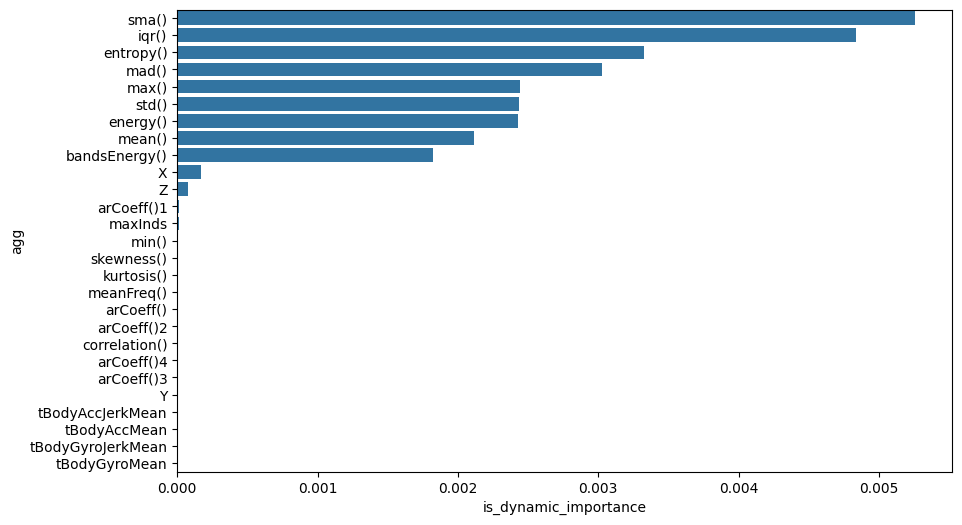

In [ ]:
# agg 별 중요도 그래프 그리기
sorted_df = merged_features.groupby('agg', as_index=False)['is_dynamic_importance'].mean().sort_values('is_dynamic_importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_df, x='is_dynamic_importance', y='agg')
plt.show()

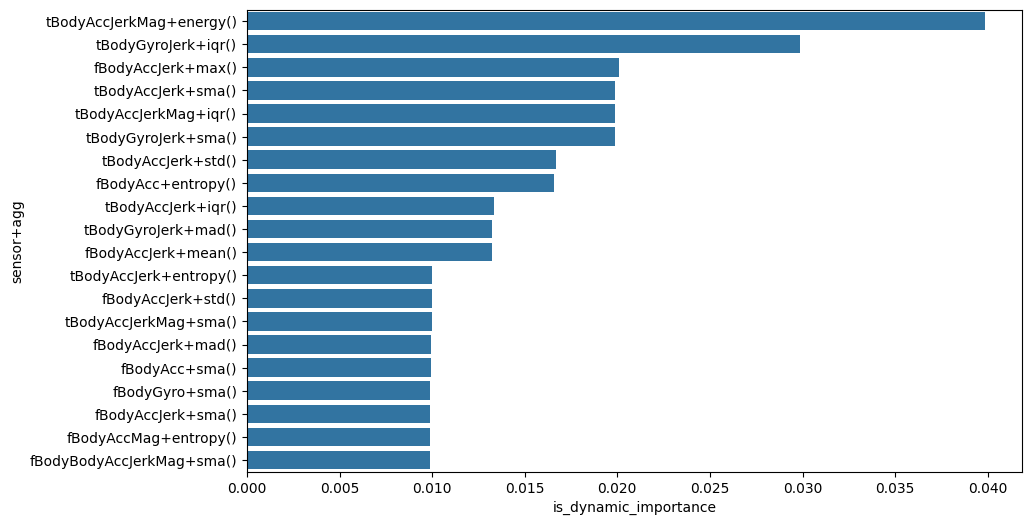

In [ ]:
# 상위 20개만 조회하여 그래프 그리기
merged_features['sensor+agg'] = merged_features['sensor'] + '+' + merged_features['agg']
sorted_df = merged_features.groupby('sensor+agg', as_index=False)['is_dynamic_importance'].mean().sort_values('is_dynamic_importance', ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(data=sorted_df, x='is_dynamic_importance', y='sensor+agg')
plt.show()

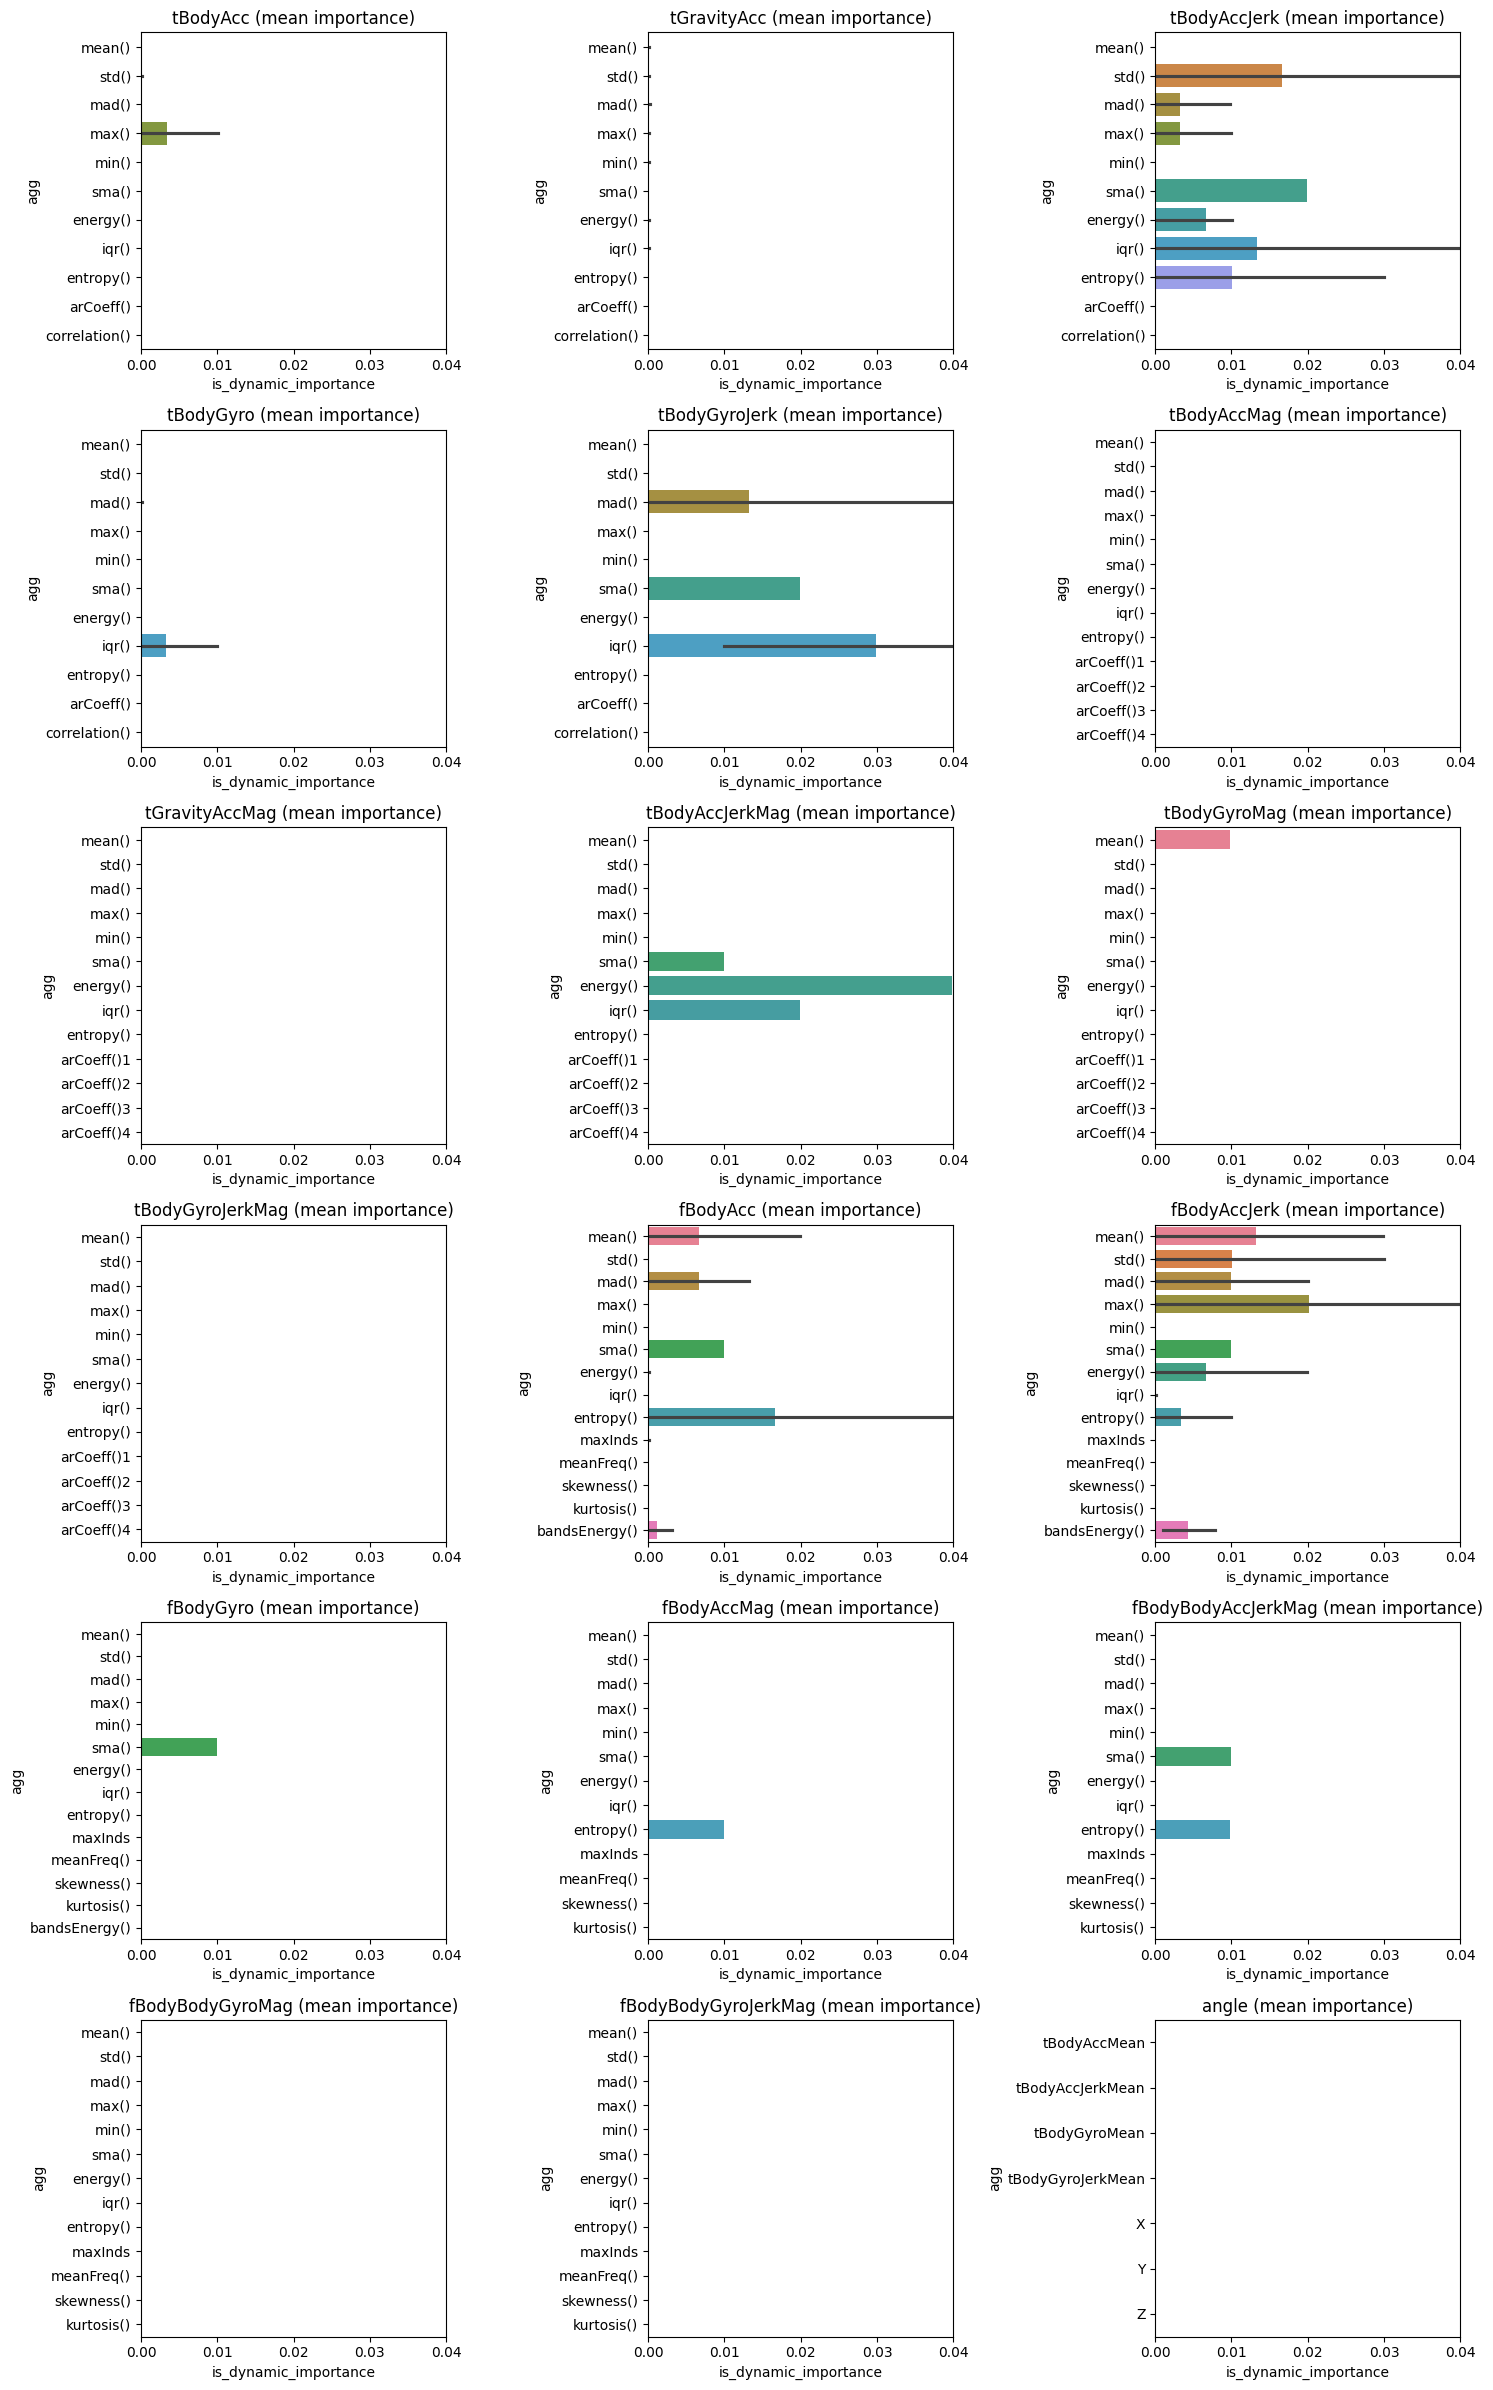

In [ ]:
# Sensor 별, agg로 나눠서 분석하기
sensors = merged_features['sensor'].unique()
n = len(sensors)

cols = 3
rows = (n + cols - 1) // cols
plt.figure(figsize=(15, 4 * rows))

for i, sensor in enumerate(sensors):
    plt.subplot(rows, cols, i + 1)
    subset = merged_features[merged_features['sensor'] == sensor]
    sns.barplot(
        data=subset,
        x='is_dynamic_importance',
        y='agg',
        hue='agg',
        estimator='mean',
    )
    plt.title(f'{sensor} (mean importance)')
    plt.xlim(0, 0.04)
plt.tight_layout()
plt.show()


### 5.데이터 분석 : 추가 과제

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_standing 추가

#### 2) 기본모델 생성

#### 3) 변수중요도 상위 5개 분석

* 상위 변수 선정

* 데이터 탐색하기

In [ ]:
# 1위

In [ ]:
# 2위

#### 4) feature 그룹별 분석

* 결과 merge

* sensor 별 중요도

* sensor + agg 별 중요도

In [ ]:
# 상위 20개만 조회


In [ ]:
# Sensor 별, agg로 나눠서 분석하기


### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_sitting 추가

#### 2) 기본모델 생성

#### 3) 변수중요도 상위 5개 분석

* 상위 변수 선정

* 데이터 탐색하기

In [ ]:
# 1위

In [ ]:
# 2위

#### 4) feature 그룹별 분석

* 결과 merge

* sensor 별 중요도

* sensor + agg 별 중요도

In [ ]:
# 상위 20개만 조회


In [ ]:
# Sensor 별, agg로 나눠서 분석하기


### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_laying 추가

#### 2) 기본모델 생성

#### 3) 변수중요도 상위 5개 분석

* 상위 변수 선정

* 데이터 탐색하기

In [ ]:
# 1위

In [ ]:
# 2위

#### 4) feature 그룹별 분석

* 결과 merge

* sensor 별 중요도

* sensor + agg 별 중요도

In [ ]:
# 상위 20개만 조회


In [ ]:
# Sensor 별, agg로 나눠서 분석하기


### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_walking 추가

#### 2) 기본모델 생성

#### 3) 변수중요도 상위 5개 분석

* 상위 변수 선정

* 데이터 탐색하기

In [ ]:
# 1위

In [ ]:
# 2위

#### 4) feature 그룹별 분석

* 결과 merge

* sensor 별 중요도

* sensor + agg 별 중요도

In [ ]:
# 상위 20개만 조회


In [ ]:
# Sensor 별, agg로 나눠서 분석하기


### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_walking_up 추가

#### 2) 기본모델 생성

#### 3) 변수중요도 상위 5개 분석

* 상위 변수 선정

* 데이터 탐색하기

In [ ]:
# 1위

In [ ]:
# 2위

#### 4) feature 그룹별 분석

* 결과 merge

* sensor 별 중요도

* sensor + agg 별 중요도

In [ ]:
# Sensor 별, agg로 나눠서 분석하기


### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_walking_up 추가

#### 2) 기본모델 생성

#### 3) 변수중요도 상위 5개 분석

* 상위 변수 선정

* 데이터 탐색하기

In [ ]:
# 1위 :

In [ ]:
# 2위

#### 4) feature 그룹별 분석

* 결과 merge

* sensor 별 중요도

* sensor + agg 별 중요도

In [ ]:
# 상위 20개만 조회


In [ ]:
# Sensor 별, agg로 나눠서 분석하기


## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [ ]:
# tip : rename을 써서 칼럼 이름 수정을 해야합니다!
target_groups = {
    "is_laying": ["LAYING"],
    "is_standing": ["STANDING"],
    "is_sitting": ["SITTING"],
    "is_walking": ["WALKING"],
    "is_walking_up": ["WALKING_UPSTAIRS"],
    "is_walking_down": ["WALKING_DOWNSTAIRS"]
}

exclude_cols = {"Activity", "is_dynamic", "y2"}
X_cols = [c for c in train.columns if c not in exclude_cols]
X_all = train[X_cols].copy()

# 각 클래스별로 반복
for col_name, label_list in target_groups.items():
    train[col_name] = train["Activity"].isin(label_list).astype(int)
    test[col_name] = test["Activity"].isin(label_list).astype(int)
    y_bin = train[col_name]
    X_tr, X_va, y_tr, y_va = train_test_split(X_all, y_bin, test_size=0.3, random_state=42)

    baseline = RandomForestClassifier(random_state=42)
    baseline.fit(X_tr, y_tr)
    fi_df = pd.DataFrame({"feature_name": baseline.feature_names_in_, f"{col_name}_importance": baseline.feature_importances_})
    merged_features = merged_features.merge(fi_df, on="feature_name", how="left")

In [ ]:
merged_features = merged_features.drop('sensor+agg', axis=1)

In [ ]:
train = train.drop('Activity', axis=1)
test = test.drop('Activity', axis=1)
train = train.rename(columns={"y2": 'Activity'})
test = test.rename(columns={"y2": 'Activity'})

#### 2) 합치기

In [ ]:
# merge 해서 2개를 합치는 작업하기

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
joblib.dump(merged_features, 'features.pkl')

['features.pkl']

In [ ]:
# joblib.dump 이용해서 colab에 .pkl 파일에 저장하기(tip: path + '파일 이름.pkl')
joblib.dump(train, 'train.pkl')
joblib.dump(test, 'test.pkl')

['test.pkl']